# Navigation Task with Multiple Selectors

In [1]:
import torch
from torch.nn.functional import softmax
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from model.kohonen_som import KohonenSOM
from model.som_q_learner import SOMQLearnerAllNeighbor
from custom_env.navigation_task import NavigationTaskMultiPurpose # distance of 0.2
import pickle
%matplotlib inline

path exception


In [2]:
random.seed(0)
torch.manual_seed(0)

## Pre-Training Pose SOM

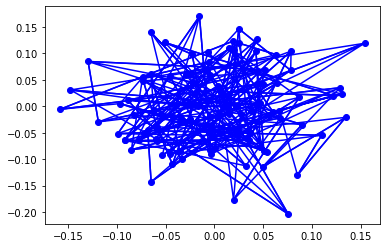

/Volumes/Macintosh HD - Data/Users/johnlime/Documents/MultipleApps/h_som/model/kohonen_som.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


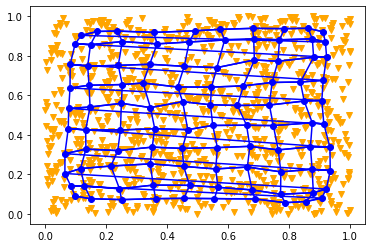

tensor([[0.0981, 0.0903],
        [0.1484, 0.0772],
        [0.2501, 0.0726],
        [0.3617, 0.0776],
        [0.4548, 0.0793],
        [0.5549, 0.0778],
        [0.6879, 0.0761],
        [0.7871, 0.0573],
        [0.8556, 0.0631],
        [0.9064, 0.0798],
        [0.0830, 0.1429],
        [0.1283, 0.1419],
        [0.2432, 0.1276],
        [0.3540, 0.1461],
        [0.4731, 0.1449],
        [0.5664, 0.1350],
        [0.6785, 0.1218],
        [0.7719, 0.0998],
        [0.8796, 0.1077],
        [0.9221, 0.1264],
        [0.0641, 0.2048],
        [0.1153, 0.2297],
        [0.2150, 0.2425],
        [0.3440, 0.2534],
        [0.4540, 0.2407],
        [0.5592, 0.2278],
        [0.6630, 0.2374],
        [0.7730, 0.2131],
        [0.8756, 0.2262],
        [0.9351, 0.2197],
        [0.0641, 0.3050],
        [0.1330, 0.3279],
        [0.2374, 0.3207],
        [0.3506, 0.3380],
        [0.4492, 0.3317],
        [0.5647, 0.3357],
        [0.6710, 0.3421],
        [0.7641, 0.3241],
        [0.8

In [3]:
"""
Initialization
"""
x = torch.rand(1000, 2)
maxitr = 10**4*5
som = KohonenSOM(total_nodes=100, node_size=2, update_iterations=maxitr)
reshaped = som.w.reshape(10, 10, 2)
for v in range(10):
    plt.plot(reshaped[:, v, 0].numpy(), reshaped[:, v, 1].numpy(), marker='None', linestyle='-', color='blue')
    plt.plot(reshaped[v, :, 0].numpy(), reshaped[v, :, 1].numpy(), marker='None', linestyle='-', color='blue')
plt.plot(som.w[:, 0].numpy(), som.w[:, 1].numpy(), marker='o', color='blue')
plt.show()

"""
Training
"""
for t in range(maxitr):
    a, c = som.update(x, t, 0)
    
pose_som_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/pose_som.obj", 'wb')
pickle.dump(som, pose_som_filehandler)
    
"""
Visualization of Trained Model
"""
plt.plot(x[:, 0].numpy(), x[:, 1].numpy(), marker='v', linestyle='None', color='orange')

pose_som_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/pose_som.obj", 'rb')
pose_som = pickle.load(pose_som_filehandler)

reshaped = som.w.reshape(10, 10, 2)
for v in range(10):
    plt.plot(reshaped[:, v, 0].numpy(), reshaped[:, v, 1].numpy(), marker='None', linestyle='-', color='blue')
    plt.plot(reshaped[v, :, 0].numpy(), reshaped[v, :, 1].numpy(), marker='None', linestyle='-', color='blue')
plt.plot(som.w[:, 0].numpy(), som.w[:, 1].numpy(), marker='o', color='blue')
plt.show()
som.w

In [4]:
pose_som_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/pose_som.obj", 'rb')
pose_som = pickle.load(pose_som_filehandler)

## Training SOM Q-Learner (Selector)

### Defining multiple tasks

In [5]:
all_tasks = []
targets = torch.rand((5, 2, 2))
for i in range(targets.shape[0]):
    all_tasks.append(NavigationTaskMultiPurpose(targets[i]))
    
task_list_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/all_tasks.obj", 'wb')
pickle.dump(all_tasks, task_list_filehandler)

### Both the state space and the Q-table are updated using self organization

In [6]:
selector_maxitr = 5 * 10 ** 2
maxtime = 1000
epsilon = 0.2

In [7]:
all_selectors = []
for i in range(targets.shape[0]):
    all_selectors.append(SOMQLearnerAllNeighbor(total_nodes=100, 
                                                state_dim = 2, 
                                                action_som = pose_som, 
                                                update_iterations=selector_maxitr))

In [8]:
for epoch in range(selector_maxitr):
    for i in range(len(all_tasks)):
        #state_trajectory = []
        
        # executed per task
        for t in range(maxtime):
            obs = all_tasks[i].state()

            # epsilon greedy
            if random.random() > epsilon:
                pose_index = all_selectors[i].get_action(obs) # deterministic

            else:
                pose_index = random.randrange(pose_som.total_nodes)

            # step forward
            reward, next_obs = all_tasks[i].step(pose_som.w[pose_index])

            # online training
            all_selectors[i].action_q_learning(
                current_state = obs,
                next_state = next_obs,
                action_index = pose_index,
                reward = reward,
                t = epoch)

            obs = next_obs
            #state_trajectory.append(np.array(obs))
            #total_return += (0.9 ** t) * reward

        all_tasks[i].reset()
    
som_q_learner_list_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/all_som_q_learners.obj", 'wb')
pickle.dump(all_selectors, som_q_learner_list_filehandler)

/Volumes/Macintosh HD - Data/Users/johnlime/Documents/MultipleApps/h_som/model/som_q_learner.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


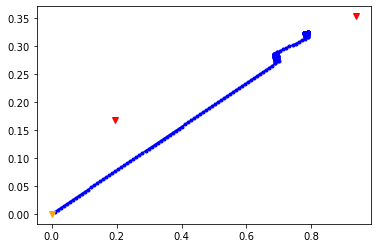

[False, False]
31.280503816000863


/Volumes/Macintosh HD - Data/Users/johnlime/Documents/MultipleApps/h_som/model/som_q_learner.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


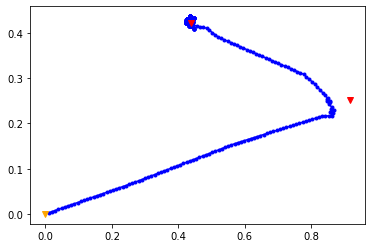

[False, False]
31.257524517922853


/Volumes/Macintosh HD - Data/Users/johnlime/Documents/MultipleApps/h_som/model/som_q_learner.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


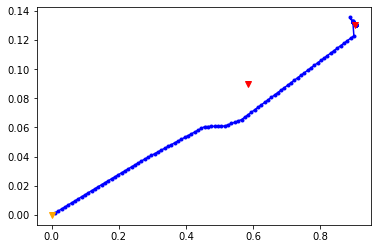

[True, True]
31.22716195867297


/Volumes/Macintosh HD - Data/Users/johnlime/Documents/MultipleApps/h_som/model/som_q_learner.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


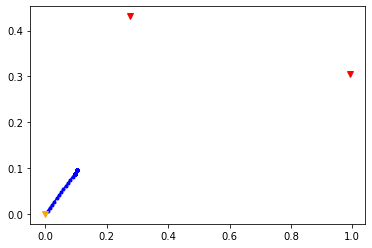

[False, False]
24.093749332503457


/Volumes/Macintosh HD - Data/Users/johnlime/Documents/MultipleApps/h_som/model/som_q_learner.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


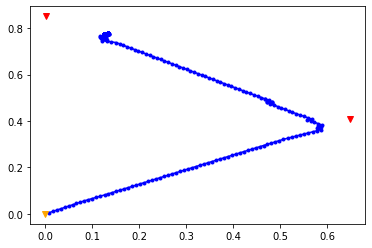

[False, False]
31.110348628646832


In [9]:
som_q_learner_list_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/all_som_q_learners.obj", 'rb')
som_q_learner_list = pickle.load(som_q_learner_list_filehandler)

task_list_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/all_tasks.obj", 'rb')
all_tasks = pickle.load(task_list_filehandler)

for i in range(len(all_tasks)):
    # for visualization
    total_return = 0
    state_trajectory = []

    for t in range(maxtime): 
        obs = all_tasks[i].state()
        pose_index = som_q_learner_list[i].get_action(obs) # deterministic

        # step forward
        reward, next_obs = all_tasks[i].step(pose_som.w[pose_index])

        obs = next_obs
        state_trajectory.append(np.array(obs))
        total_return += (0.9 ** t) * reward

    # visualization
    plt.plot(np.array(state_trajectory)[:, 0], np.array(state_trajectory)[:, 1], marker='.', linestyle='-', color='blue')
    plt.plot(0.0, 0.0, marker='v', linestyle='None', color='orange')

    for g in range(all_tasks[i].all_goals.shape[0]):
        plt.plot(np.array(all_tasks[i].all_goals[g])[0], 
                 np.array(all_tasks[i].all_goals[g])[1], 
                 marker='v', linestyle='None', color='red')

    plt.show()
    print(all_tasks[i].goal_completed)
    print(total_return)

    all_tasks[i].reset()

## Visualization of SOMs

In [10]:
from IPython.display import Image

def visualize_som(som, columns, labels = ["", ""], dim = 10, location = False):
    if location:
        reshaped_x = som.location[:, columns[0]].reshape(dim, dim)
        reshaped_y = som.location[:, columns[1]].reshape(dim, dim)
        for v in range(dim):
            plt.plot(reshaped_x[:, v].numpy(), reshaped_y[:, v].numpy(), marker='None', linestyle='-', color='blue')
            plt.plot(reshaped_x[v, :].numpy(), reshaped_y[v, :].numpy(), marker='None', linestyle='-', color='blue')
        plt.plot(som.location[:, columns[0]].numpy(), som.location[:, columns[1]].numpy(), marker='o', color='blue')
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
        plt.show()
        
    else:
        reshaped_x = som.w[:, columns[0]].reshape(dim, dim)
        reshaped_y = som.w[:, columns[1]].reshape(dim, dim)
        for v in range(dim):
            plt.plot(reshaped_x[:, v].numpy(), reshaped_y[:, v].numpy(), marker='None', linestyle='-', color='blue')
            plt.plot(reshaped_x[v, :].numpy(), reshaped_y[v, :].numpy(), marker='None', linestyle='-', color='blue')
        plt.plot(som.w[:, columns[0]].numpy(), som.w[:, columns[1]].numpy(), marker='o', color='blue')
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
        plt.show()

In [11]:
def softmax_matrix(torch_matrix):
    matrix_size = torch_matrix.shape
    softmax_matrix = torch.zeros(matrix_size)
    for i in range(matrix_size[0]):
        softmax_matrix[i] = softmax(torch_matrix[i])
    return softmax_matrix

In [12]:
pose_som_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/pose_som.obj", 'rb')
pose_som = pickle.load(pose_som_filehandler)

som_q_learner_list_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/all_som_q_learners.obj", 'rb')
som_q_learner_list = pickle.load(som_q_learner_list_filehandler)

task_list_filehandler = open("../data/selector_pose_ik/navigation_task_multi_purpose/all_tasks.obj", 'rb')
all_tasks = pickle.load(task_list_filehandler)

### Distribution of State Space within the SOM

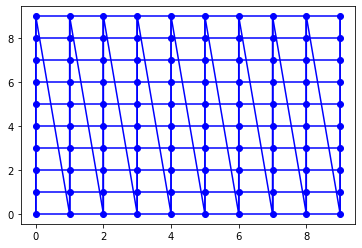

Selector:  0


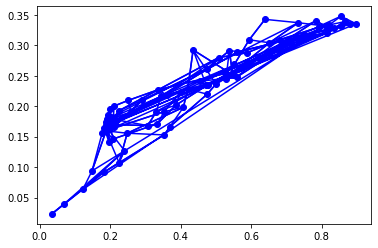

Selector:  1


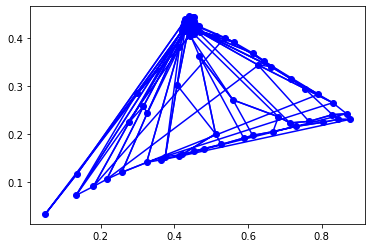

Selector:  2


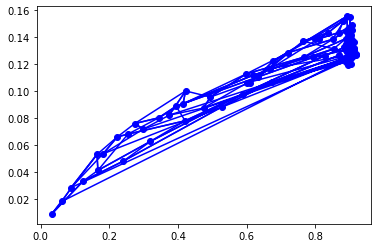

Selector:  3


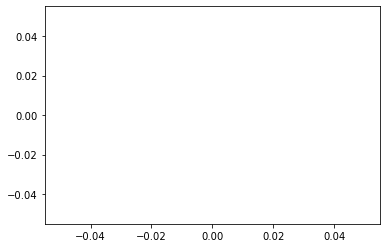

Selector:  4


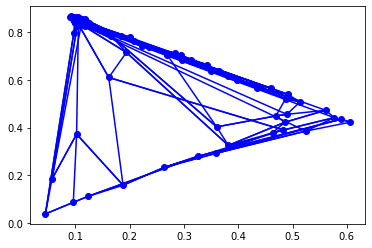

In [13]:
visualize_som(pose_som, [0, 1], location = True)
for i in range(len(som_q_learner_list)):
    print("Selector: ", i)
    visualize_som(som_q_learner_list[i], [0, 1])

### Poses used by the Selector

In [14]:
for i in range(len(som_q_learner_list)):
    print("Selector: ", i)
    print(som_q_learner_list[i].w.shape)
#     print("Softmax Matrix")
#     print(softmax_matrix(som_q_learner_list[i].w[:, 2:]))
    print("Action Matrix")
    print(torch.argmax(softmax_matrix(som_q_learner_list[i].w[:, 2:]), dim=1).reshape(10, 10))

Selector:  0
torch.Size([100, 102])
Action Matrix
tensor([[38, 38, 38, 38, 38, 38, 38, 38, 11, 38],
        [38, 38, 38, 38, 38, 11, 11, 38, 38, 38],
        [38,  0, 38, 96, 38, 11, 38, 11, 38, 20],
        [38, 95, 56, 38, 38, 38, 38, 38, 38, 26],
        [10, 40, 21, 10, 38, 11, 39, 38, 26, 26],
        [38, 38,  0,  0, 11, 11, 11, 20, 26, 37],
        [30, 12, 21, 10, 11, 11, 11, 11, 20, 38],
        [23,  1, 63, 11, 11, 11, 11, 38, 20, 25],
        [ 1,  1,  1,  0, 11, 11, 38, 38, 11, 11],
        [12,  1,  1,  0, 11, 11, 38, 38, 11, 11]])
Selector:  1
torch.Size([100, 102])
Action Matrix
tensor([[27, 27, 27, 28, 28, 28, 28, 28, 29, 37],
        [27, 27, 29, 60, 29, 28, 28, 28, 29, 37],
        [27, 27, 68, 54, 60, 60, 43, 50, 36, 37],
        [27, 68, 76, 76, 54, 60, 43, 50, 36, 70],
        [27, 13, 68, 49,  6, 51, 60, 43, 50, 50],
        [28, 13, 51, 49,  2, 99,  0, 51, 50, 50],
        [28, 13, 40, 16,  2,  1, 32, 43, 32, 43],
        [28, 68, 49, 93,  4,  4,  2,  2, 43, 43],

<ipython-input-11-02bca1d072b0>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_matrix[i] = softmax(torch_matrix[i])


In [15]:
pose_usage = []
for i in range(len(som_q_learner_list)):
    print("Selector: ", i)
    pose_usage.append(torch.unique(torch.argmax(softmax_matrix(som_q_learner_list[i].w[:, 2:]), dim=1), 
                                   return_counts = True))
    print("Pose in Use", pose_usage[i][0])
    print("Frequency of Pose", pose_usage[i][1])

Selector:  0
Pose in Use tensor([ 0,  1, 10, 11, 12, 20, 21, 23, 25, 26, 30, 37, 38, 39, 40, 56, 63, 95,
        96])
Frequency of Pose tensor([ 5,  6,  3, 25,  2,  4,  2,  1,  1,  4,  1,  1, 39,  1,  1,  1,  1,  1,
         1])
Selector:  1
Pose in Use tensor([ 0,  1,  2,  4,  6, 13, 15, 16, 27, 28, 29, 32, 36, 37, 40, 43, 49, 50,
        51, 54, 60, 68, 70, 76, 93, 99])
Frequency of Pose tensor([ 1,  1,  8,  8,  1,  5,  1,  4,  9, 12,  4,  3,  2,  3,  1,  7,  5,  6,
         3,  2,  5,  4,  1,  2,  1,  1])
Selector:  2
Pose in Use tensor([ 0,  2,  4,  5,  6,  8,  9, 17, 19, 20, 23, 24, 26, 29, 30, 40, 45, 58,
        68, 74, 76, 97])
Frequency of Pose tensor([ 1,  6,  1,  3,  1,  5, 13,  8, 44,  1,  1,  2,  1,  1,  1,  1,  1,  1,
         4,  2,  1,  1])
Selector:  3
Pose in Use tensor([0])
Frequency of Pose tensor([100])
Selector:  4
Pose in Use tensor([ 5,  6, 19, 22, 28, 31, 45, 46, 47, 49, 57, 59, 60, 61, 62, 63, 70, 71,
        74, 79, 80, 82, 87, 90, 91, 92, 94])
Frequency of P

<ipython-input-11-02bca1d072b0>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_matrix[i] = softmax(torch_matrix[i])


Selector:  0
tensor([ 5.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 25.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  4.,  2.,  0.,  1.,  0.,  1.,  4.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 39.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.])
Pose Usage


<ipython-input-16-d6af69ca0891>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pose_heat_map = softmax(pose_heat_map.float())


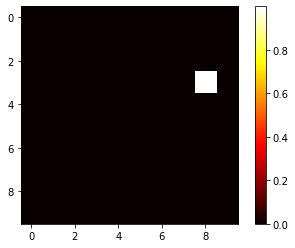

Selector:  1
tensor([ 1.,  1.,  8.,  0.,  8.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
         0.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,
        12.,  4.,  0.,  0.,  3.,  0.,  0.,  0.,  2.,  3.,  0.,  0.,  1.,  0.,
         0.,  7.,  0.,  0.,  0.,  0.,  0.,  5.,  6.,  3.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.])
Pose Usage


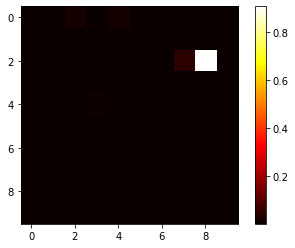

Selector:  2
tensor([ 1.,  0.,  6.,  0.,  1.,  3.,  1.,  0.,  5., 13.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  8.,  0., 44.,  1.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.])
Pose Usage


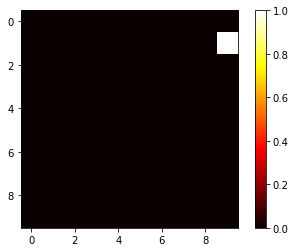

Selector:  3
tensor([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.])
Pose Usage


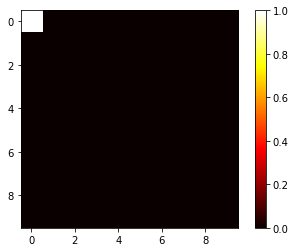

Selector:  4
tensor([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  1.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  7.,  1.,  1.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         7., 11.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3., 41.,  0.,  1.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.])
Pose Usage


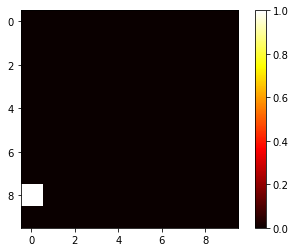

In [16]:
for i in range(len(pose_usage)):
    print("Selector: ", i)
    pose_heat_map = torch.zeros(100)

    for p, a in zip(pose_usage[i][0], range(len(pose_usage[i][0]))):
        pose_heat_map[p] = pose_usage[i][1][a]

    print(pose_heat_map)
    pose_heat_map = softmax(pose_heat_map.float())

    print("Pose Usage")
    plt.imshow(pose_heat_map.reshape(10, 10), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [17]:
baseline_maxtime = maxtime
baseline_gamma = 0.9
for i in range(len(all_tasks)):
    baseline_return = 0
    for t in range(baseline_maxtime):
        reward, _ = all_tasks[i].step(all_tasks[i].goal)
        baseline_return += (baseline_gamma ** t) * reward

    all_tasks[i].reset()
    print(baseline_return)

31.41515361181495
31.413419449281502
31.41356373593734
31.414172286249173
31.415337643785758
